In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as TF
from sklearn.metrics import confusion_matrix

In [2]:
import os

In [3]:
def show_sample_image(data_dir, classes):
    plt.figure(figsize=(15, 3))
    for idx, class_name in enumerate(classes, 1):
        try:
            class_dir = data_dir / class_name
            first_file = next(class_dir.glob('*.jpg'))
            img = Image.open(first_file)
            plt.subplot(1, len(classes), idx)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        except (StopIteration, FileNotFoundError):
            print(f"No images found in {class_name}")
        except Exception as e:
            print(f"Error with {class_name}: {e}")
    plt.tight_layout()
    plt.show()

In [4]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, img_size=128):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            # Second Convolution Block
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (img_size // 4) * (img_size // 4), 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
 # For applying transforms on subsets

class TransformedDataset(Dataset):
    
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.subset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.subset)




def prepare_data_loaders(data_dir, img_size, batch_size, validation_split, num_workers=0):
    """
    Fnc. to prepare  with image augmentation
       -train data loaders   &  -validation data loaders 
                      
    Args:
        data_dir (Path): Root dir of the dataset.
        img_size (int): Size (height and width) to resize images.
        batch_size (int): # of samples per batch.
        validation_split (float): % split of data-splitting for validation.
    
    Returns:
        train_loader, val_loader, classes
    """
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop((img_size, img_size), scale=(0.9, 1.1)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        # here could be added eventualy additional rotation 
        transforms.RandomRotation(72),
        transforms.ToTensor(),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    full_dataset = ImageFolder(root=str(data_dir))
    
    # Data Splitting:
    dataset_size = len(full_dataset)
    train_size = int((1 - validation_split) * dataset_size)
    val_size = dataset_size - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])
    
   

    train_dataset = TransformedDataset(train_subset, train_transforms)
    val_dataset = TransformedDataset(val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, full_dataset.classes

In [6]:
# Plotting
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))
    
    # Accr. plot
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [26]:
# model Evaluaton  and plot of the confusion matrix.
def evaluate_and_plot_predictions(model, val_loader, classes):
    """    
    Args:
        model (nn.Module): The trained CNN model.
        val_loader (DataLoader): DataLoader for the validation set.
        classes (list): List of class names.
        
    Returns:
        dict: Metrics including accuracy and confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    correct = (np.array(all_preds) == np.array(all_labels)).sum()
    total = len(all_labels)
    accuracy = correct / total
    print(f"\nValidation Accuracy: {accuracy:.4f}")

    # normalized confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return {'accuracy': accuracy, 'confusion_matrix': cm}

In [27]:
# Hyperparameters and training settings

img_size = 128
batch_size = 32
epochs = 10  # EPOCHS !
validation_split = 0.2  # 0.x : x := x% of dataset = Validation
learning_rate = 0.001  # Learning Rate
patience = 5  # early stopping patience

classes = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
data_dir = Path("/Users/keitasakurai/PycharmProjects/CDB/blood_cell_images")
model_save_dir = Path("models")

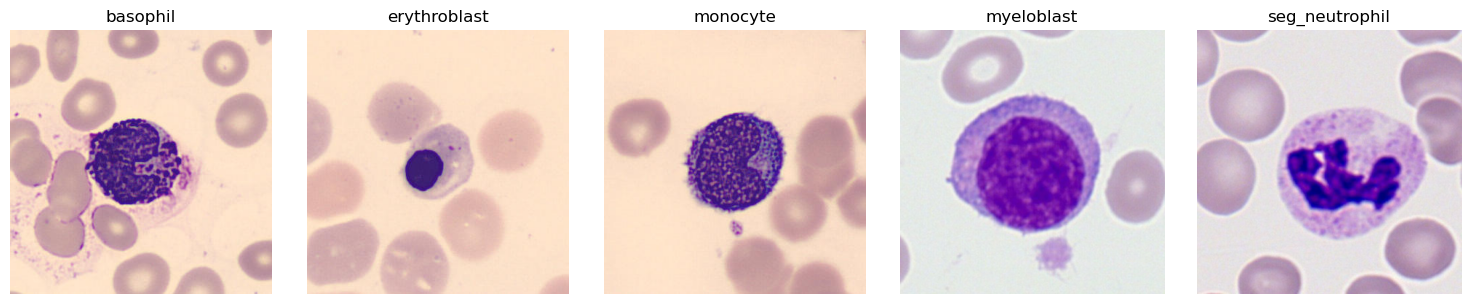

In [28]:
# Show sample images from the dataset
show_sample_image(data_dir, classes)

In [29]:
# Data loaders

train_loader, val_loader, class_names = prepare_data_loaders(
    data_dir=data_dir,
    img_size=img_size,
    batch_size=batch_size,
    validation_split=validation_split
)

In [30]:
# Model initialization

model = CNNModel(num_classes=len(class_names), img_size=img_size)
print("Model architecture:")
print(model)

Model architecture:
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=32, out_features=5, bias=True)

In [31]:
# Define loss, optimizer, and learning rate scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3)

In [32]:
# Tracking variables for training history

best_val_loss = float('inf')
no_improve = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
from pathlib import Path

In [34]:
def train_one_epoch(model, train_loader, optimizer, criterion):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

In [35]:
def validate_one_epoch(model, val_loader, criterion):

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [36]:
def save_best_model(model, model_save_dir, val_loss, best_val_loss):

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_save_dir.mkdir(exist_ok=True)
        torch.save(model.state_dict(), model_save_dir / 'best_model.pth')
    return best_val_loss

In [37]:
def print_epoch_results(epoch, epochs, train_loss, train_acc, val_loss, val_acc):

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

In [38]:
def early_stopping_check(val_loss, best_val_loss, no_improve, patience):

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered!")
            return True, best_val_loss, no_improve
    
    return False, best_val_loss, no_improve

In [39]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, patience, model_save_dir):
    best_val_loss = float('inf')
    no_improve = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        
        print_epoch_results(epoch, epochs, train_loss, train_acc, val_loss, val_acc)
        
        best_val_loss = save_best_model(model, model_save_dir, val_loss, best_val_loss)
        
        stop_training, best_val_loss, no_improve = early_stopping_check(val_loss, best_val_loss, no_improve, patience)
        if stop_training:
            break

    return train_losses, val_losses, train_accs, val_accs

In [40]:
# Hyperparameters and training settings
img_size = 128
batch_size = 32
epochs = 10
validation_split = 0.2
learning_rate = 0.001
patience = 5
classes = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
data_dir = Path("/Users/keitasakurai/PycharmProjects/CDB/blood_cell_images")
model_save_dir = Path("models")

train_loader, val_loader, class_names = prepare_data_loaders(
    data_dir=data_dir,
    img_size=img_size,
    batch_size=batch_size,
    validation_split=validation_split,
    num_workers=0
)

model = CNNModel(num_classes=len(class_names), img_size=img_size)
print("Model architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3)

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, patience, model_save_dir
)

Model architecture:
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=32, out_features=5, bias=True)

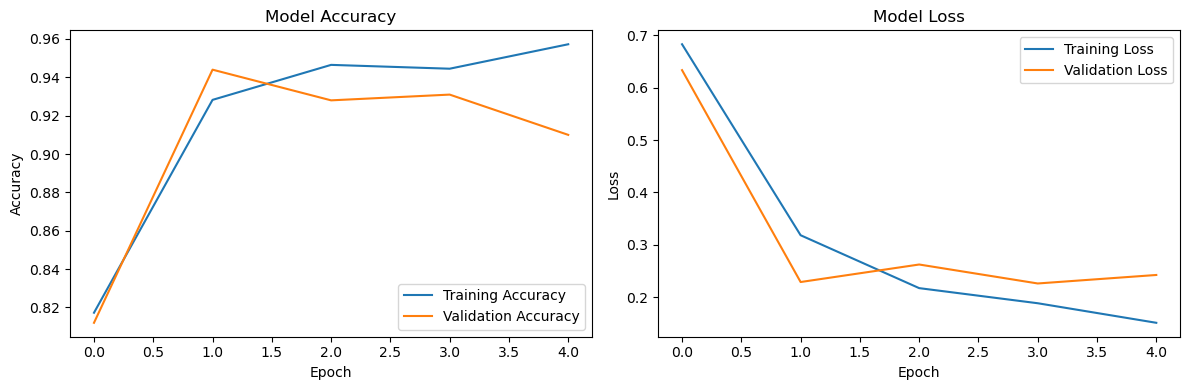

In [41]:
# Plot training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)


Validation Accuracy: 0.9100


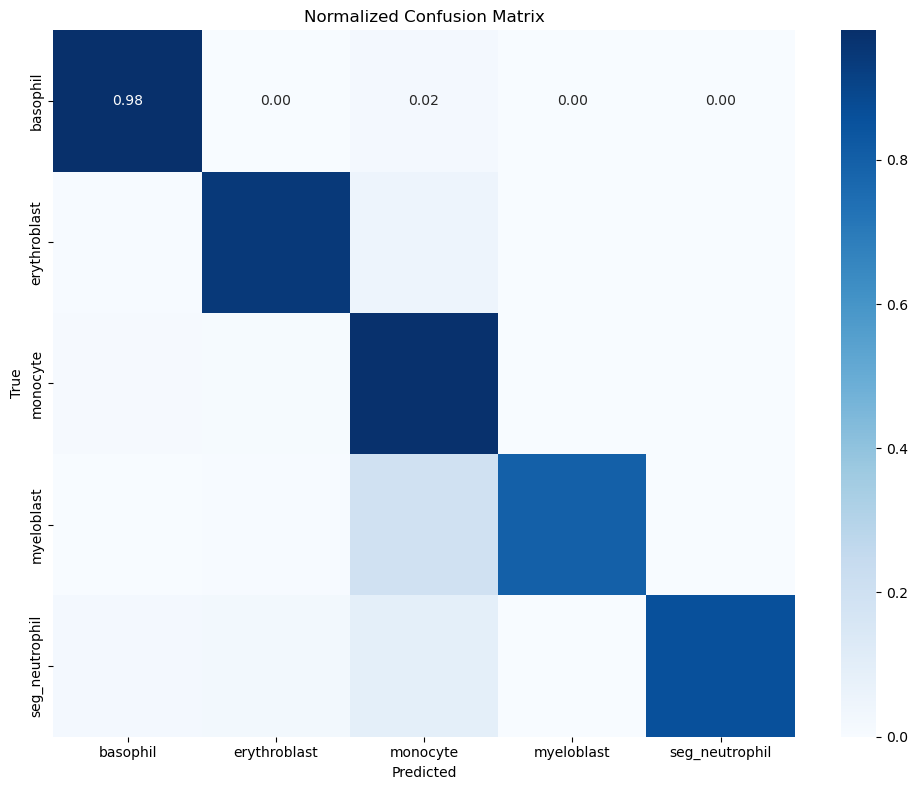

NameError: name 'all_labels' is not defined

In [45]:
# Evaluate the model and plot confusion matrix
metrics = evaluate_and_plot_predictions(model, val_loader, class_names)

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

print("Evaluation Metrics:", metrics)

In [43]:
# Save the final model
torch.save(model.state_dict(), model_save_dir / 'CNN_model.pth')
print(f"Model saved to {model_save_dir / 'CNN_model.pth'}")

Model saved to models/CNN_model.pth
